In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("/content/hotel_bookings.csv")

In [3]:
# Phase 1: Exploratory Data Analysis (EDA)
print("Shape:", df.shape)
print("\n--- Info ---")
print(df.info())
print("\n--- Describe ---")
print(df.describe(include="all").T.head(15))



Shape: (103785, 32)

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103785 entries, 0 to 103784
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           103785 non-null  object 
 1   is_canceled                     103784 non-null  float64
 2   lead_time                       103784 non-null  float64
 3   arrival_date_year               103784 non-null  float64
 4   arrival_date_month              103784 non-null  object 
 5   arrival_date_week_number        103784 non-null  float64
 6   arrival_date_day_of_month       103784 non-null  float64
 7   stays_in_weekend_nights         103784 non-null  float64
 8   stays_in_week_nights            103784 non-null  float64
 9   adults                          103784 non-null  float64
 10  children                        103780 non-null  float64
 11  babies                          103784 non-n

In [4]:
missing = df.isnull().sum().sort_values(ascending=False)
print("\n--- Missing Values ---")
print(missing[missing > 0])



--- Missing Values ---
company                           97612
agent                             14919
country                             489
children                              5
arrival_date_day_of_month             1
arrival_date_week_number              1
is_canceled                           1
lead_time                             1
babies                                1
stays_in_weekend_nights               1
adults                                1
stays_in_week_nights                  1
market_segment                        1
meal                                  1
arrival_date_year                     1
arrival_date_month                    1
deposit_type                          1
distribution_channel                  1
previous_bookings_not_canceled        1
is_repeated_guest                     1
reserved_room_type                    1
assigned_room_type                    1
booking_changes                       1
previous_cancellations                1
required_car_par

<Figure size 1000x600 with 0 Axes>

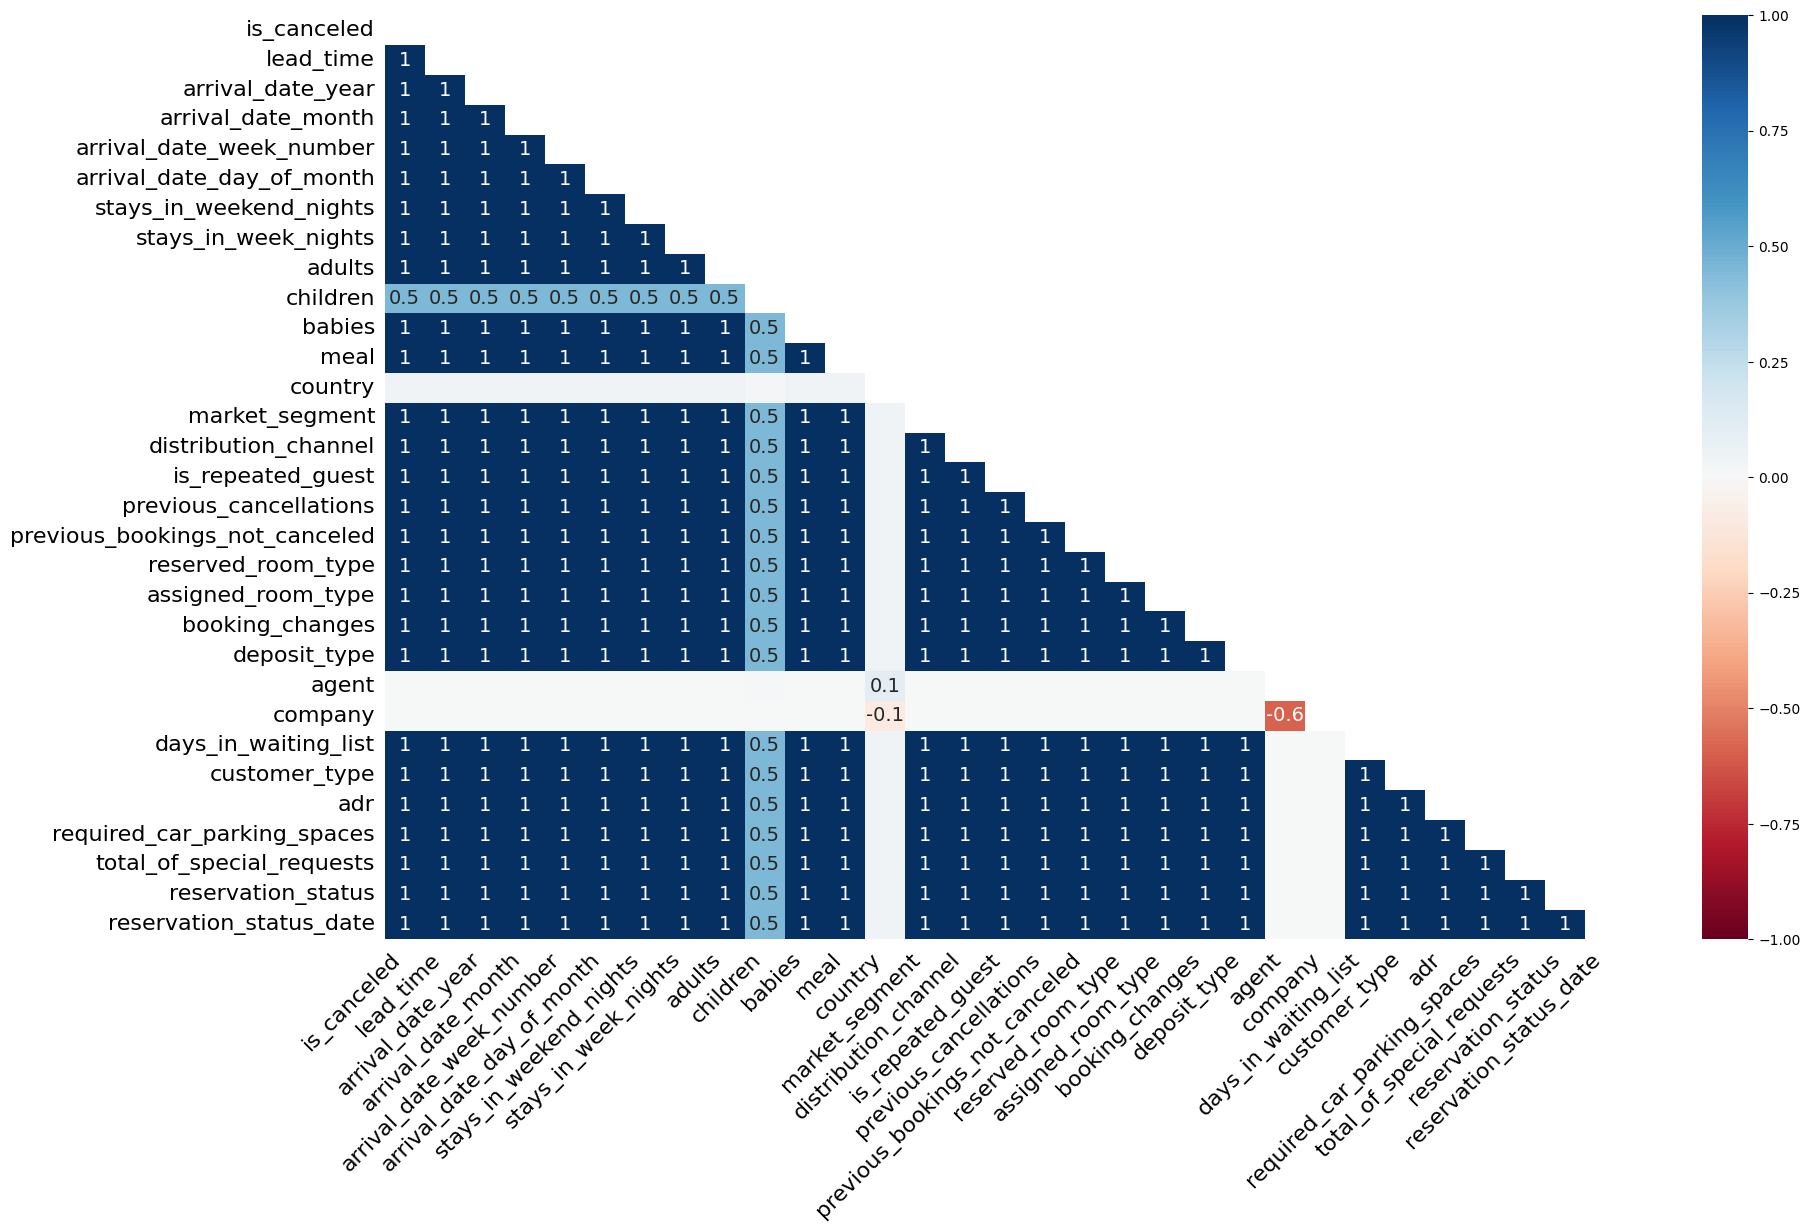

In [5]:
plt.figure(figsize=(10,6))
msno.heatmap(df)
plt.show()

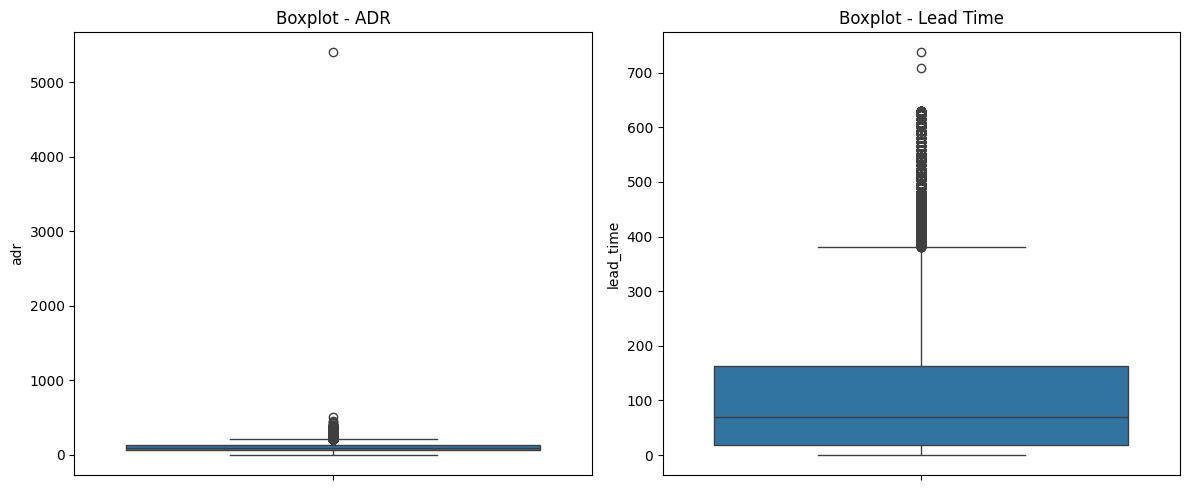

In [6]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(y=df['adr'])
plt.title("Boxplot - ADR")

plt.subplot(1,2,2)
sns.boxplot(y=df['lead_time'])
plt.title("Boxplot - Lead Time")

plt.tight_layout()
plt.show()

In [12]:
# Phase 2: Data Cleaning
df['company'] = df['company'].fillna(0)         # replace NaN with 0
df['agent'] = df['agent'].fillna(0)             # replace NaN with 0
df['country'] = df['country'].fillna(df['country'].mode()[0])  # mode imputation
df['children'] = df['children'].fillna(df['children'].median()) # median imputation


In [9]:
print("Before duplicates removal:", df.shape)
df.drop_duplicates(inplace=True)
print("After duplicates removal:", df.shape)

Before duplicates removal: (103785, 32)
After duplicates removal: (74342, 32)


In [10]:
df.loc[df['adr'] < 0, 'adr'] = 0   # fix negatives
df.loc[df['adr'] > 1000, 'adr'] = 1000  # cap extreme

In [11]:
# Fix data types
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Drop leakage columns
df = df.drop(['reservation_status', 'reservation_status_date'], axis=1)

In [15]:
# Phase 3: Feature Engineering & Preprocessing


# Create new features
df['total_guests'] = df['adults'] + df['children'] + df['babies']
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['is_family'] = np.where((df['children'] + df['babies']) > 0, 1, 0)

# Encode categorical variables
# One-Hot Encoding for low-cardinality features
low_card_cols = ['meal', 'market_segment', 'distribution_channel',
                 'reserved_room_type', 'assigned_room_type',
                 'deposit_type', 'customer_type', 'hotel']

# Check which of the specified columns are actually in the dataframe
valid_low_card_cols = [col for col in low_card_cols if col in df.columns]

df = pd.get_dummies(df, columns=valid_low_card_cols, drop_first=True)
country_freq = df['country'].value_counts(normalize=True)
df['country'] = df['country'].map(country_freq)

# Fill remaining NaN in 'is_canceled' before splitting
df['is_canceled'] = df['is_canceled'].fillna(df['is_canceled'].mode()[0])

train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['is_canceled'])

print("\n--- Final Dataset Shapes ---")
print("Train:", train.shape)
print("Test:", test.shape)

train.head()


--- Final Dataset Shapes ---
Train: (59473, 67)
Test: (14869, 67)


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,hotel_City Hotel,hotel_Resort Hotel
19628,0.0,0.0,2015.0,December,53.0,28.0,1.0,0.0,1.0,0.0,...,False,False,False,False,False,False,True,False,False,True
63677,1.0,63.0,2017.0,February,7.0,17.0,0.0,2.0,2.0,0.0,...,False,False,False,False,False,False,True,False,True,False
35481,0.0,62.0,2017.0,April,16.0,19.0,1.0,4.0,1.0,0.0,...,False,False,False,False,False,False,False,True,False,True
70661,1.0,126.0,2017.0,June,25.0,20.0,0.0,3.0,3.0,0.0,...,False,False,False,False,False,False,True,False,True,False
33483,0.0,20.0,2017.0,February,8.0,20.0,1.0,4.0,2.0,2.0,...,False,False,False,False,False,False,True,False,False,True
